##### Установка библиотек и импорт датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
df = pd.read_csv(r'C:\Users\serov_av\MLOps-my-testrep\data\raw\Tomato.csv', sep = ',', parse_dates = ['Date'])
print(df.head())
FONTSIZE = 14

        Date Unit  Minimum  Maximum  Average  Market
0 2013-06-16   Kg       26       32     29.0  Tomato
1 2013-06-17   Kg       20       25     22.5  Tomato
2 2013-06-18   Kg       22       26     24.0  Tomato
3 2013-06-19   Kg       24       28     26.0  Tomato
4 2013-06-20   Kg       22       26     24.0  Tomato


#### 1.	Найти среднегодовые и среднемесячные показатели, отразить на графике полные и усредненные данные

##### Добавление столбцов со среднемесячными и среднегодовыми значениями

In [2]:
dfavg=df.copy(deep=True)
dfavg['AnnualAvg'] = dfavg.groupby(dfavg.Date.dt.year)['Average'].transform('mean')
dfavg['MonthAvg'] = dfavg.groupby(dfavg.Date.dt.month)['Average'].transform('mean')

##### Построение графика

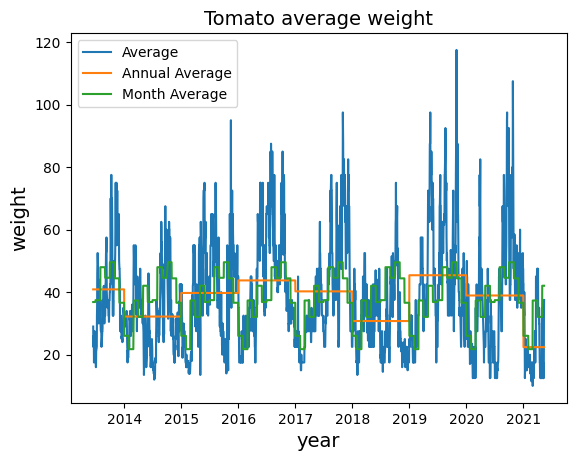

In [3]:
plt.plot (dfavg['Date'], dfavg['Average'], label='Average')
plt.plot (dfavg['Date'], dfavg['AnnualAvg'], label='Annual Average')
plt.plot (dfavg['Date'], dfavg['MonthAvg'], label='Month Average')
plt.title ('Tomato average weight', fontsize=FONTSIZE)
plt.xlabel('year', fontsize=FONTSIZE)
plt.ylabel('weight', fontsize=FONTSIZE)
plt.legend()
plt.show ()

#### 2. Найти даты с минимальным (Minimum) весом за все время, заменить эти значения на nan, удалить строки с nan, рассчитать абсолютную разницу в среднегодовых значениях до и после удаления строк

##### Нахождение дат с минимальным значением, замена значений на nan и удаление

In [4]:
mindf= df.copy(deep=True)
mindf[mindf['Minimum']== min(mindf['Minimum'])]= 'nan'
mindf.drop(mindf[mindf['Minimum']=='nan'].index, inplace=True)

C:\Users\serov_av\AppData\Local\Temp\ipykernel_964\966342879.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mindf[mindf['Minimum']== min(mindf['Minimum'])]= 'nan'
C:\Users\serov_av\AppData\Local\Temp\ipykernel_964\966342879.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mindf[mindf['Minimum']== min(mindf['Minimum'])]= 'nan'


##### Расчет среднегодовых значений после удаления строк.

In [5]:
mindf['AnnualAvg']= mindf.groupby(mindf.Date.dt.year)['Average'].transform('mean')

##### Расчет абсолютной разницы (под абсолютной разницей понималась разность максимального и минимального среднегодового значения)

In [6]:
absdif1= max(mindf['AnnualAvg'])- min(mindf['AnnualAvg'])
absdif2= max(dfavg['AnnualAvg'])- min(dfavg['AnnualAvg'])
print("Изнчальная абсолютная разница среднегодовых значений", "%.2f" % absdif2)
print("Абсолютная разница среднегодовых значений после удаления минимальных", "%.2f" % absdif1)

Изнчальная абсолютная разница среднегодовых значений 23.00
Абсолютная разница среднегодовых значений после удаления минимальных 22.73


#### 3. Построить прогноз на десять лет любым доступным способом, найти стандартное отклонение и медиану за весь период

##### Импорт необходимых библиотек и использование даты как индекса

In [8]:
import statistics as st
import xgboost as xgb
import sklearn as sk
dfxbg= pd.read_csv(r'C:\Users\serov_av\MLOps-my-testrep\data\raw\Tomato.csv', sep= ',', parse_dates= ['Date'], index_col= ['Date'])
dfxbg.head()

Unit  Minimum  Maximum  Average  Market
Date                                              
2013-06-16   Kg       26       32     29.0  Tomato
2013-06-17   Kg       20       25     22.5  Tomato
2013-06-18   Kg       22       26     24.0  Tomato
2013-06-19   Kg       24       28     26.0  Tomato
2013-06-20   Kg       22       26     24.0  Tomato

##### Удаление ненужных столбцов и добавление feature столбцов

In [9]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    dfxgb= dfxbg.drop(['Maximum','Minimum','Unit','Market'], axis= 1)
    return dfxgb

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    dfxgb['Dayofyear']= dfxgb.index.day_of_year
    dfxgb['Month']= dfxgb.index.month
    FEATURES = ['Dayofyear', 'Month']
    TARGET = ['Average']
    return dfxgb

##### Сплит данных на тестовую и обучающую выборку

In [10]:
train = dfxgb.loc[dfxgb.index<'01-01-2020']
test = dfxgb.loc[dfxgb.index>='01-01-2020']

##### Разбивка выборок на целевую переменную и feature переменные

In [11]:
x_train = train[FEATURES]
y_train = train[TARGET]
x_test = test[FEATURES]
y_test = test[TARGET]

##### Поскольку данные являются непрерывными была выбрана модель регрессии

In [12]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose = False)

c:\Users\serov_av\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\serov_av\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\serov_av\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\serov_av\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##### Создание датасета с будущими данными за 10 лет, применение модели и соединение с изначальными данными

In [13]:
dti = pd.date_range(start="2021-05-14", end="2031-05-13", freq="D")
df_future=pd.DataFrame(dti,columns=['Date'])
df_future['Date'] = pd.to_datetime(df_future['Date'])
df_future=df_future.set_index('Date')
df_future['Dayofyear'] = df_future.index.day_of_year
df_future['Month'] = df_future.index.month
df_future['Average'] = reg.predict(df_future)
dfxgb=pd.concat([dfxgb, df_future], ignore_index=False, axis=0)

c:\Users\serov_av\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\serov_av\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\serov_av\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\serov_av\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

##### Расчет стандартного отклонения и медианы

In [14]:
print("Standard Deviation is", "%.2f" % st.stdev(dfxgb['Average']))
print("Median is", "%.2f" % st.median(dfxgb['Average']))

Standard Deviation is 12.43
Median is 38.42


#### 4. Визуализировать результаты прогноза, реальные данные и прогноз следует вынести разными цветами

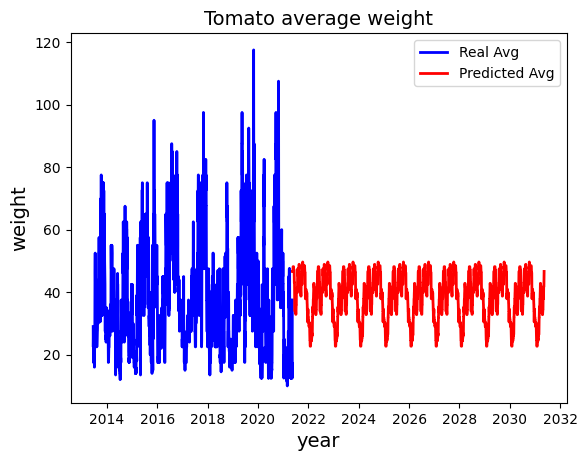

In [15]:
sg1 = dfxgb.loc[dfxgb.index<'2021-05-14']
sg2 = dfxgb.loc[dfxgb.index>='2021-05-14']
plt.plot(sg1.index, sg1['Average'], '-b', lw=2, label = "Real Avg")
plt.plot(sg2.index, sg2['Average'], '-r', lw=2, label = "Predicted Avg")
plt.title ('Tomato average weight', fontsize=FONTSIZE)
plt.xlabel('year', fontsize=FONTSIZE)
plt.ylabel('weight', fontsize=FONTSIZE)
plt.legend()
plt.show()

#### 5. Сделать выводы о зависимости значений от сезонности и результатам прогноза

##### Сезонность имеет большое значение, на графике четко видно, что в зимний период средний вес плода значительно уменьшается, а в теплые времена года растет

#### 6.	Реализовать запрос от пользователя: пользователь вводит дату, программа выводит сообщение со значениями в этот день, а также график, где точкой выделена эта дата

##### Запрос на ввод даты 

In [16]:
import datetime
year = (input('Введите год в диапазоне 2013 - 2031: '))
while year.isdigit() == False:
    year = (input('Некорректный год, введите год в диапазоне 2013 - 2031: '))
month = (input('Введите месяц: '))
while month.isdigit() == False:
    month = (input('Некорректный месяц, введите месяц: '))
day = (input('Введите день: '))
while day.isdigit() == False:
    day= (input('Некорректный день, введите день: '))

format = '%Y-%m-%d'
d = year + "-" + month + "-" + day
d = datetime.datetime.strptime(d, format)
d = d.date()
d = d.isoformat()

##### Вывод среднего значения веса томата за указанную дату

In [17]:
query = dfxgb.loc[dfxgb.index==d]
print("Среднее значение веса томатов в эту дату- ", query['Average'])

Среднее значение веса томатов в эту дату-  Date
2017-05-15    40.0
Name: Average, dtype: float64


##### Построение графика с точкой на выбранной дате

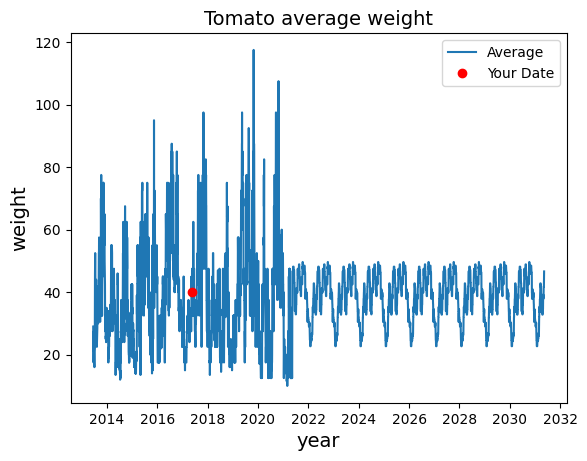

In [18]:
plt.plot(dfxgb.index, dfxgb['Average'], label = "Average")
plt.plot(query.index, query['Average'], 'ro', label = "Your Date")
plt.xlabel('year', fontsize=FONTSIZE)
plt.ylabel('weight', fontsize=FONTSIZE)
plt.title ('Tomato average weight', fontsize=FONTSIZE)
plt.legend()
plt.show()